# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [3]:
vgg16 = VGG16(weights='imagenet',
               input_shape=(32,32,3),include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


In [4]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,849,610
Trainable params: 14,849,098
Non-trainable params: 512
__________________________________________

In [6]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)

resnet50 = ResNet50(weights=None, input_shape=None, include_top=True)

xception = Xception(weights=None, input_shape=None, include_top=True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#### 데이터 로드

In [18]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
  /content/cats_and_dogs_filtered.zip

--2020-09-14 09:52:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 172.253.117.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   210MB/s    in 0.3s    

2020-09-14 09:52:52 (210 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [19]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

In [21]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [22]:
train_cats_dir = os.path.join(train_dir,'cats')

train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')

validationdogs_dir = os.path.join(validation_dir,'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [26]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

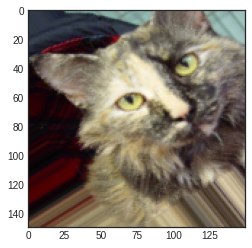

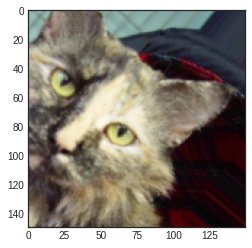

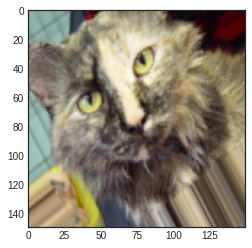

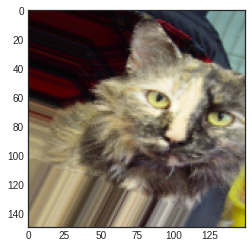

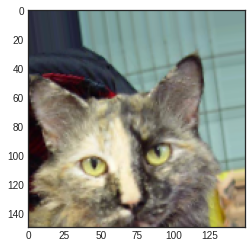

In [32]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path,target_size=(150,150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x,batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 ==0:
    break

#### 학습, 검증 데이터셋의 Data Generator

In [33]:
train_datagen = ImageDataGenerator(
    rescale= 1./255 ,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./225)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [36]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [38]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 16s - loss: 0.5011 - acc: 0.7570 - val_loss: 0.5200 - val_acc: 0.7520
Epoch 2/30
100/100 - 16s - loss: 0.4898 - acc: 0.7575 - val_loss: 0.4992 - val_acc: 0.7600
Epoch 3/30
100/100 - 16s - loss: 0.4842 - acc: 0.7610 - val_loss: 0.4763 - val_acc: 0.7630
Epoch 4/30
100/100 - 16s - loss: 0.4864 - acc: 0.7650 - val_loss: 0.4665 - val_acc: 0.7630
Epoch 5/30
100/100 - 16s - loss: 0.4879 - acc: 0.7600 - val_loss: 0.4716 - val_acc: 0.7670
Epoch 6/30
100/100 - 16s - loss: 0.4810 - acc: 0.7625 - val_loss: 0.4864 - val_acc: 0.7480
Epoch 7/30
100/100 - 16s - loss: 0.4760 - acc: 0.7685 - val_loss: 0.4937 - val_acc: 0.7600
Epoch 8/30
100/100 - 16s - loss: 0.4657 - acc: 0.7765 - val_loss: 0.4596 - val_acc: 0.7710
Epoch 9/30
100/100 - 17s - loss: 0.4685 - acc: 0.7735 - val_loss: 0.5130 - val_acc: 0.7620
Epoch 10/30
100/100 - 16s - loss: 0.4759 - acc: 0.7670 - val_loss: 0.4493 - val_acc: 0.7680
Epoch 11/30
100/100 - 17s - loss: 0.4675 - acc: 0.7705 - val_loss: 0.4461 - val_acc: 0.76

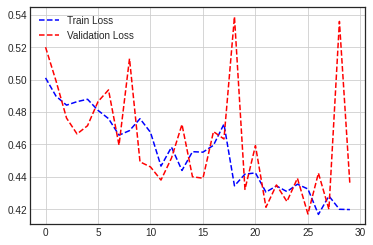

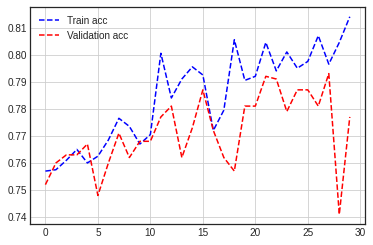

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss,'b--',label='Train Loss')
plt.plot(epochs, val_loss,'r--',label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs, acc,'b--',label='Train acc')
plt.plot(epochs, val_acc,'r--',label='Validation acc')
plt.grid()
plt.legend()
plt.show()

#### 모델 저장

In [44]:
model.save('cats_and_dogs_model.h5')

### 사전 훈련된 모델 사용

In [51]:
conv_base = VGG16(weights='imagenet',
                 input_shape=(150,150,3), include_top=False)

In [54]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=2e-5),
                metrics = ['accuracy'])
  return model

파라미터의 수 확인!

In [55]:
model  = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [56]:
print(len(model.trainable_weights))

30


In [57]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [58]:
model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=2e-5),
                metrics = ['accuracy'])

#### 이미지 제너레이터

In [59]:
train_datagen = ImageDataGenerator(
    rescale= 1./255 ,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./225)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [61]:
history2 = model.fit(train_generator,
                      steps_per_epoch = 100,
                      epochs=30,
                      batch_size=256,
                      validation_data=validation_generator,
                      validation_steps=50,
                      verbose=2)

Epoch 1/30
100/100 - 19s - loss: 0.5875 - accuracy: 0.6945 - val_loss: 0.4657 - val_accuracy: 0.7820
Epoch 2/30
100/100 - 19s - loss: 0.4893 - accuracy: 0.7725 - val_loss: 0.3757 - val_accuracy: 0.8330
Epoch 3/30
100/100 - 18s - loss: 0.4354 - accuracy: 0.8155 - val_loss: 0.3267 - val_accuracy: 0.8620
Epoch 4/30
100/100 - 18s - loss: 0.3989 - accuracy: 0.8410 - val_loss: 0.3198 - val_accuracy: 0.8560
Epoch 5/30
100/100 - 19s - loss: 0.3836 - accuracy: 0.8360 - val_loss: 0.3078 - val_accuracy: 0.8590
Epoch 6/30
100/100 - 18s - loss: 0.3683 - accuracy: 0.8435 - val_loss: 0.2884 - val_accuracy: 0.8800
Epoch 7/30
100/100 - 19s - loss: 0.3587 - accuracy: 0.8350 - val_loss: 0.2766 - val_accuracy: 0.8840
Epoch 8/30
100/100 - 18s - loss: 0.3450 - accuracy: 0.8505 - val_loss: 0.3082 - val_accuracy: 0.8640
Epoch 9/30
100/100 - 18s - loss: 0.3431 - accuracy: 0.8500 - val_loss: 0.2659 - val_accuracy: 0.8890
Epoch 10/30
100/100 - 19s - loss: 0.3274 - accuracy: 0.8575 - val_loss: 0.2524 - val_accura

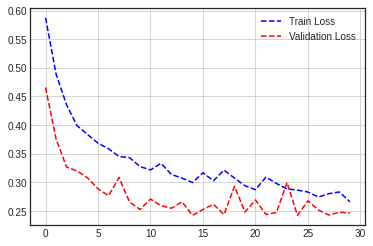

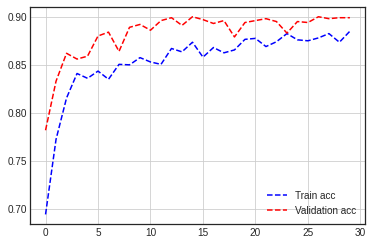

In [62]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss,'b--',label='Train Loss')
plt.plot(epochs, val_loss,'r--',label='Validation Loss')
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs, acc,'b--',label='Train acc')
plt.plot(epochs, val_acc,'r--',label='Validation acc')
plt.grid()
plt.legend()
plt.show()

#### 모델 저장

In [63]:
model.save('cats_and_dogs_with_pretrained_model.h5')

## Feature Map 시각화

In [65]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

### 모델 구성

In [67]:
model = load_model('/content/cats_and_dogs_model.h5')

In [71]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis,...]
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


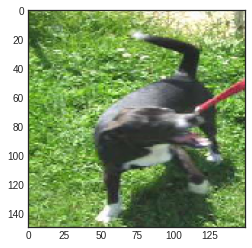

In [72]:
plt.imshow(img_tensor[0])
plt.show()

In [73]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<tf.Tensor 'conv2d_16/Relu_1:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_8/MaxPool_1:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_17/Relu_1:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_9/MaxPool_1:0' shape=(None, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_18/Relu_1:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_10/MaxPool_1:0' shape=(None, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_19/Relu_1:0' shape=(None, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_11/MaxPool_1:0' shape=(None, 7, 7, 128) dtype=float32>]

In [77]:
activation_model = Model(inputs=[model.input],outputs=conv_output)

In [78]:
activations = activation_model.predict(img_tensor)

In [79]:
len(activations)

8

### 시각화

(1, 148, 148, 32)


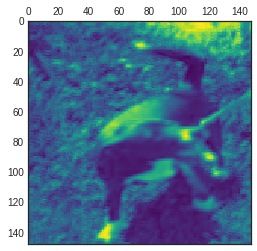

In [85]:
print(activations[0].shape)
plt.matshow(activations[0][0,:,:,7],cmap='viridis')
plt.show()

(1, 148, 148, 32)


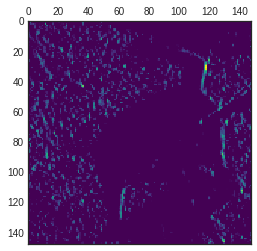

In [83]:
print(activations[0].shape)
plt.matshow(activations[0][0,:,:,10],cmap='viridis')
plt.show()

(1, 148, 148, 32)


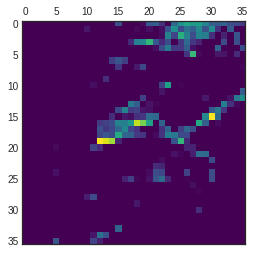

In [84]:
print(activations[0].shape)
plt.matshow(activations[3][0,:,:,20],cmap='viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

In [89]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]

  num_cols = num_features // images_per_row
  display_grid = np.zeros((size * num_cols, images_per_row * size))

  for col in range(num_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:,:,col*images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image,0,255).astype('uint8')
      display_grid[col * size: (col + 1) * size, row * size :(row +1) * size] = channel_image

  scale = 1. / size

  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid,aspect='auto', cmap='viridis')

plt.show()

Output hidden; open in https://colab.research.google.com to view.